In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from time import time
import tensorflow as tf


# Crop yield dataset

In [ ]:
df = pd.read_csv("crop_yield_dataset.csv")
df = df.set_index('Date')
df.drop("Crop_Type",axis=1,inplace=True)
wheat = df.iloc[::10].copy()
corn = df.iloc[1::10].copy()
rice = df.iloc[2::10].copy()
barley = df.iloc[3::10].copy()
soybean = df.iloc[4::10].copy()
cotton = df.iloc[5::10].copy()
sugarcane = df.iloc[6::10].copy()
tomato = df.iloc[7::10].copy()
potato = df.iloc[8::10].copy()
sunflower = df.iloc[9::10].copy()

# Define features and target
X = wheat[["Temperature", "Humidity"]].values  # Features: Temperature and Humidity
y = wheat["Crop_Yield"].values  # Target: Crop Yield

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(2921, 2), y_train=(2921,)
Testing data shape: X_test=(731, 2), y_test=(731,)


In [ ]:
df.shape

(3652, 3)

In [ ]:
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(X_train)
df_for_testing_scaled=scaler.transform(X_test)
#df_for_training_scaled

In [ ]:
def createXY(dataset,time_step):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step):
            dataX.append(dataset[i:i + time_step])
            dataY.append(dataset[i + time_step][0])
    return np.array(dataX),np.array(dataY)


In [ ]:
X_train, y_train=createXY(df_for_training_scaled,10)
X_test,y_test=createXY(df_for_testing_scaled,10)

In [ ]:
print("trainX Shape-- ",X_train.shape)
print("trainY Shape-- ",y_train.shape)

trainX Shape--  (2911, 10, 2)
trainY Shape--  (2911,)


In [ ]:
# hyperparameter tuning for number of layers and batch size
param_grid = {
    'layers': [2,3], #LSTM layers
    'units1': [150,100],
    'units2': [100,50] #number of LSTM units
}

In [ ]:
def evaluate_model(layers,units1,units2):
    model = Sequential()
    n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
    for i in range(layers-1): #add one layer per number inputted
        model.add(LSTM(units2,activation='relu',input_shape=(n_timesteps, n_features),return_sequences=True))
    model.add(LSTM(units1,activation='relu',return_sequences=False))
    model.add(Dense(1)) #1 output
    model.compile(optimizer='adam',loss='mae')

    epochs = 50
    validation_split = 0.2
    batch_size = 64
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
    y_pred = model.predict(X_test, verbose=0)

    mae = np.sqrt(mean_absolute_error(y_test,y_pred))

    return mae


In [ ]:

best_mae = 0.3276
best_params = {'layers': 3, 'units1': 150, 'units2': 50}

In [ ]:
best_mae = 1
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {params}")
    mae = evaluate_model(params['layers'], params['units1'],params['units2'])
    print(f"MAE: {mae:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae:.4f}")

Testing with parameters: {'layers': 2, 'units1': 150, 'units2': 100}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_mae:.4f}")

Best Parameters: {'layers': 3, 'units1': 150, 'units2': 50}
Best RMSE: 0.3276


In [ ]:
# train model with best params
n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
model_LSTM = Sequential()
model_LSTM.add(LSTM(150, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True)) #return_sequences is necessary for stacked LSTM so that output includes timestamps (3D)
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(100, activation='relu', return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50, activation='relu'))
model_LSTM.add(Dense(1)) #3 output variables (yield, temperature, humidity)
model_LSTM.compile(optimizer='adam', loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
epochs = 40
validation_split = 0.2
batch_size = 64

st = time()
model_LSTM_trained = model_LSTM.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
et = time()
train_t_LSTM = et-st

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.2225 - val_loss: 0.1379
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1295 - val_loss: 0.1390
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1293 - val_loss: 0.1332
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1316 - val_loss: 0.1332
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1299 - val_loss: 0.1343
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1279 - val_loss: 0.1433
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1294 - val_loss: 0.1370
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1287 - val_loss: 0.1339
Epoch 9/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.1302 - val_loss: 0.1331
Epoch 10/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1285 - val_loss: 0.1355
Epoch 11/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1270 - val_loss: 0.1336
Epoch 12/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1

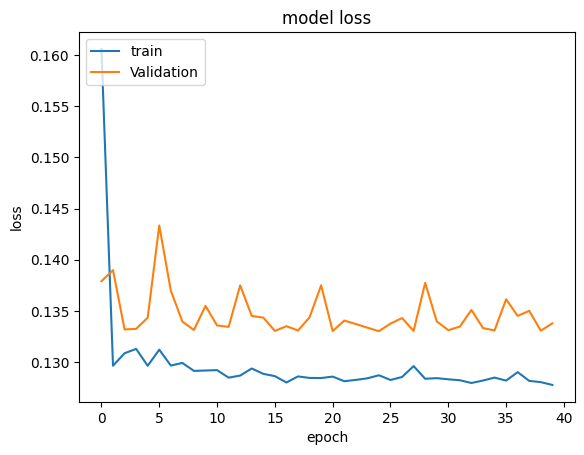

In [ ]:
plt.plot(model_LSTM_trained.history['loss'])
plt.plot(model_LSTM_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
# Evaluate LSTM
loss_lstm = model_LSTM.evaluate(X_test, y_test, verbose=0)
y_pred_lstm = model_LSTM.predict(X_test, verbose=0)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test,y_pred_lstm)

print(f"LSTM Loss (MAE): {loss_lstm}")
print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM Time: {train_t_LSTM}")

LSTM Loss (MAE): 0.12790361046791077
LSTM RMSE: 0.1550440009658443
LSTM Time: 176.12346410751343


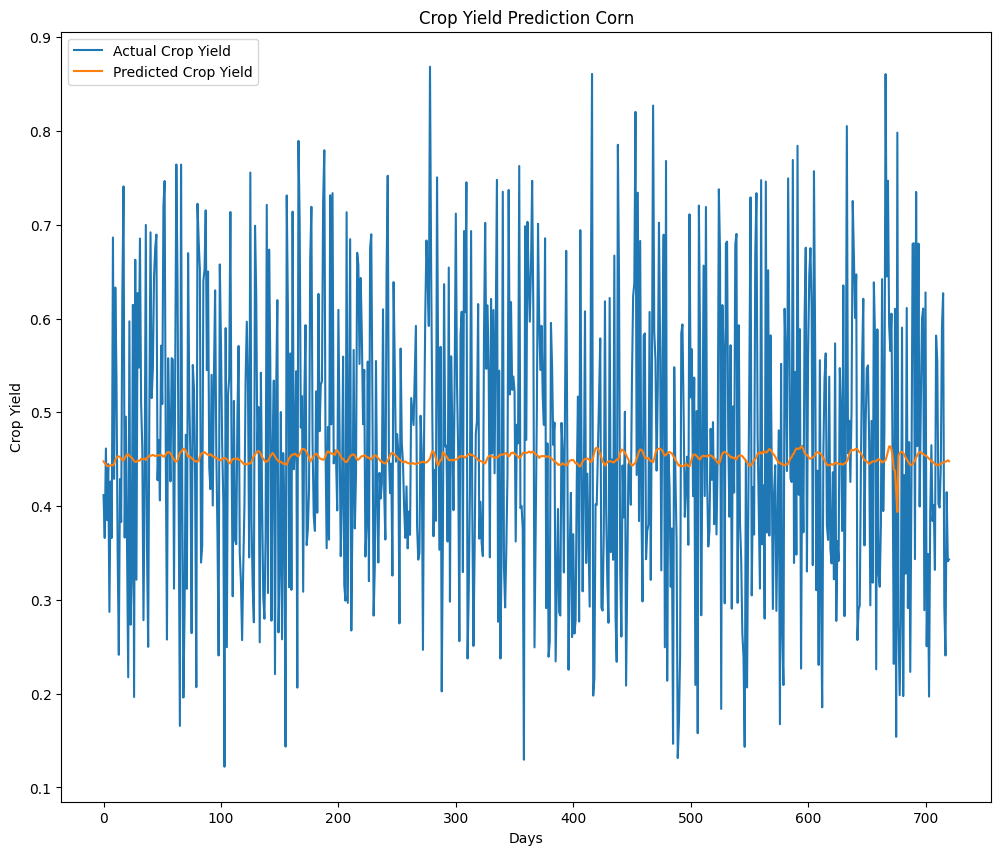

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(y_test, label="Actual Crop Yield")
plt.plot(y_pred_lstm, label="Predicted Crop Yield")
plt.title('Crop Yield Prediction Corn')
plt.xlabel('Days')
plt.ylabel('Crop Yield')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

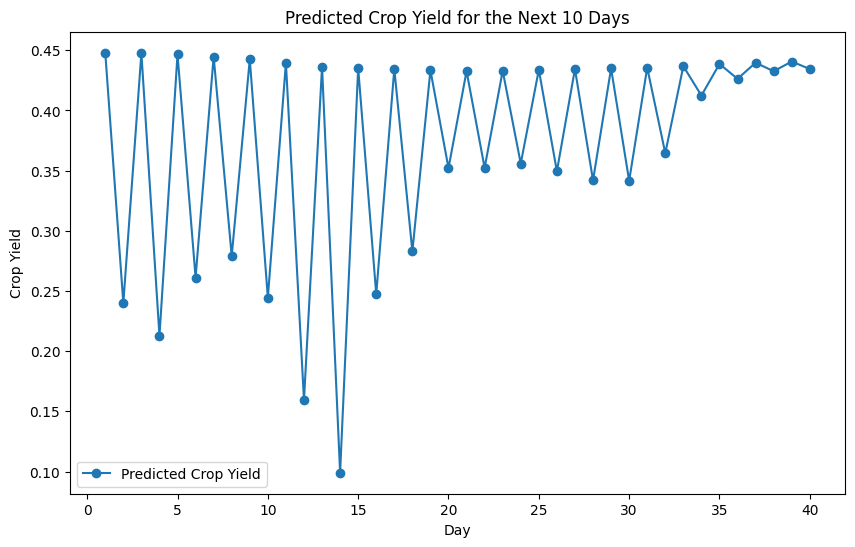

In [66]:
last_input = X_test[-1]  # Get the last input from the test set
predictions = []

for i in range(40):
    # Reshape last_input for prediction
    next_pred = model_LSTM.predict(last_input.reshape((1, 10, 2)))
    predictions.append(next_pred[0][0])

    # Prepare next input: append the new prediction and shift the window (if time series)
    # Adjust the last_input based on how your data is structured
    last_input = np.roll(last_input, -1)  # Shift left by 1
    last_input[-1] = next_pred  # Add new prediction at the end

# Print predicted temperatures for the next 10 days
print("Predicted temperatures for the next 10 days:", predictions)

# Visualize the predicted temperatures for the next 10 days
plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), predictions, marker='o', linestyle='-', label='Predicted Crop Yield')
plt.xlabel('Day')
plt.ylabel('Crop Yield')
plt.title('Predicted Crop Yield for the Next 10 Days')
plt.legend()
plt.show()

In [67]:
# Define model
from tensorflow.keras.layers import GRU, Dense

model_GRU = Sequential()
model_GRU.add(GRU(100, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))  # return_sequences is necessary for stacked GRU
model_GRU.add(GRU(50, activation='relu'))
model_GRU.add(Dense(1))

model_GRU.compile(optimizer='adam', loss='mae')
epochs = 50
validation_split = 0.2
batch_size = 16

model_GRU_trained = model_GRU.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=False,shuffle=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


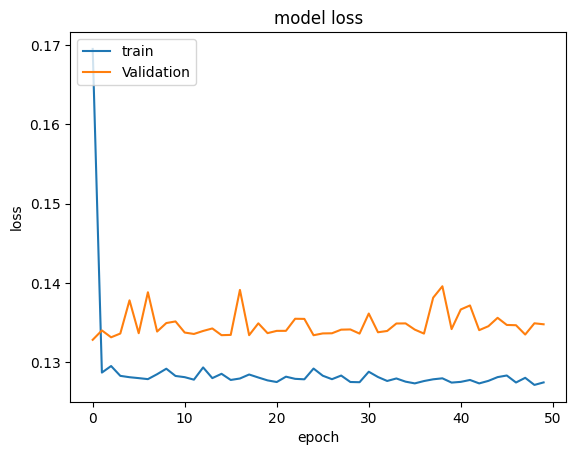

In [68]:

plt.plot(model_GRU_trained.history['loss'])
plt.plot(model_GRU_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [69]:
# Evaluate LSTM
loss_GRU= model_GRU.evaluate(X_test, y_test, verbose=0)
y_pred_GRU = model_LSTM.predict(X_test, verbose=0)
mae_GRU = mean_absolute_error(y_test, y_pred_GRU)
rmse_GRU = root_mean_squared_error(y_test,y_pred_GRU)

print(f"LSTM Loss (MAE): {loss_GRU}")
print(f"LSTM RMSE: {rmse_GRU}")


LSTM Loss (MAE): 0.12783531844615936
LSTM RMSE: 0.1550440009658443


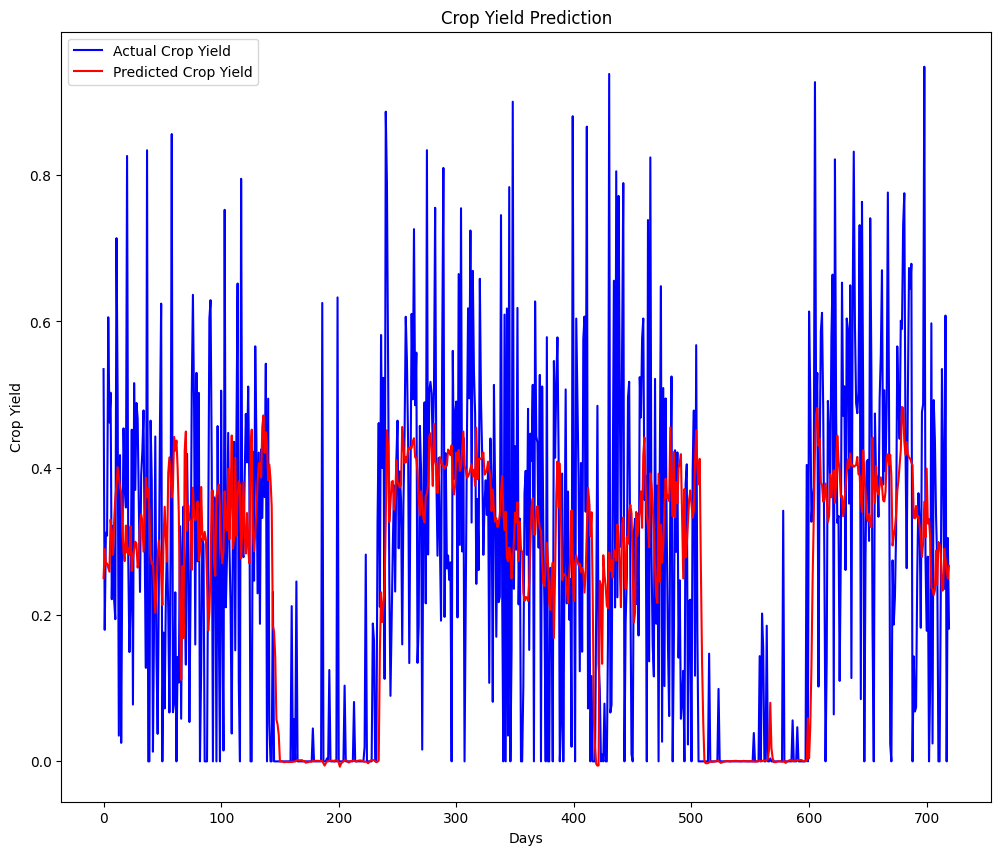

In [ ]:
# Initialize starting input for forecasting (last time step from X_test)
starting_input = X_test[-1].reshape(1, n_timesteps, n_features)  # Shape: (1, n_timesteps, n_features)

# Set the number of days to forecast
forecast_days = 10
forecast = []  # Empty list to hold the forecasted values

# Iterative forecasting
for day in range(forecast_days):
    next_prediction = model_GRU.predict(starting_input, verbose=0)  # Predict next value
    forecast.append(next_prediction.flatten())  # Append prediction to forecast list

    # Prepare next input: Slide the window
    next_input = starting_input[:, 1:, :]  # Remove the oldest time step
    # Adjust dimensions to match input features
    next_prediction_adjusted = np.tile(next_prediction.flatten(), (1, n_features))  # Repeat the prediction for all features
    next_input = np.append(next_input, next_prediction_adjusted.reshape(1, 1, n_features), axis=1)  # Add the new prediction
    starting_input = next_input  # Update input for next iteration

# Convert forecast list to a numpy array
forecast = np.array(forecast)

# Plot the Forecasted vs Actual Values
# Assuming the first column in y_test corresponds to crop yield
plt.figure(figsize=(12,10))
plt.plot(y_test[:, 0], label="Actual Crop Yield", color='blue')  # Plot only the crop yield (first column)
plt.plot(y_pred_lstm[:, 0], label="Predicted Crop Yield", color='red')  # Plot the predicted crop yield (first column)
plt.title('Crop Yield Prediction')
plt.xlabel('Days')
plt.ylabel('Crop Yield')
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

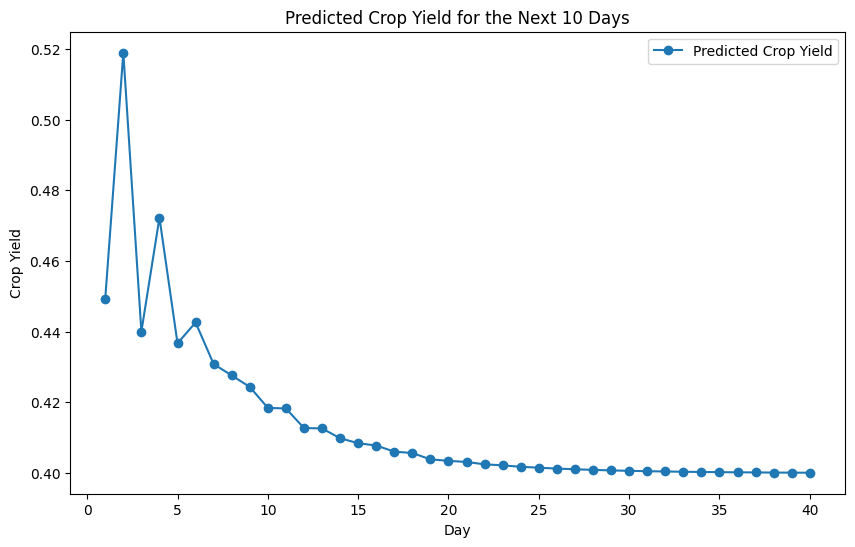

In [70]:
last_input = X_test[-1]  # Get the last input from the test set
predictions = []

for i in range(40):
    # Reshape last_input for prediction
    next_pred = model_GRU.predict(last_input.reshape((1, 10, 2)))
    predictions.append(next_pred[0][0])

    # Prepare next input: append the new prediction and shift the window (if time series)
    # Adjust the last_input based on how your data is structured
    last_input = np.roll(last_input, -1)  # Shift left by 1
    last_input[-1] = next_pred  # Add new prediction at the end

# Print predicted temperatures for the next 10 days
print("Predicted temperatures for the next 10 days:", predictions)

# Visualize the predicted temperatures for the next 10 days
plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), predictions, marker='o', linestyle='-', label='Predicted Crop Yield')
plt.xlabel('Day')
plt.ylabel('Crop Yield')
plt.title('Predicted Crop Yield for the Next 10 Days')
plt.legend()
plt.show()